# 고양이, 개 분류 - CNN v2
- Dropout 추가
- 이미지를 중앙에 배치
- 각 이미지를 10개씩 부풀려 파일로 저장하고 이 파일로 학습

In [2]:
import cv2, os
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-01-23 08:54:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   197MB/s    in 0.3s    

2022-01-23 08:54:10 (197 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
!unzip cats_and_dogs_filtered.zip > /dev/null

- 데이터 탐색

In [5]:
# 이미지를 축소/확대 및 센터링해서 이미지를 리턴하는 함수
IMAGE_SIZE = 150

def center_image(img, format='Image'):
    """입력 img 포맷은 Pillow image, 반환 포맷은 numpy array"""
    if format == 'Image' :              # pillow image
        h, w, _ = np.array(img).shape
    else:                               # numpy array
        h, w = img.shape[:-1]
    if h > w:
        width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
    else:
        width, height = (w * IMAGE_SIZE) // h, IMAGE_SIZE

    new_img = np.array(img.resize((width,height)))

    diff = abs(width - height)//2
    if width > height:
        final_img = new_img[:, diff:diff+IMAGE_SIZE, :]
    else:
        final_img = new_img[diff:diff+IMAGE_SIZE, :, :]

    return Image.fromarray(final_img) if format == 'Image' else final_img

In [6]:
CENTER_DIR = 'cats_and_dogs_centered'
train_dir = f'{CENTER_DIR}/train'
validation_dir = f'{CENTER_DIR}/validation'
train_cats_dir = f'{CENTER_DIR}/train/cats'
train_dogs_dir = f'{CENTER_DIR}/train/dogs'
validation_cats_dir = f'{CENTER_DIR}/validation/cats'
validation_dogs_dir = f'{CENTER_DIR}/validation/dogs'

In [7]:
if not os.path.exists(CENTER_DIR):
    os.mkdir(CENTER_DIR)
for dir in [train_dir,validation_dir,train_cats_dir,train_dogs_dir,validation_cats_dir,validation_dogs_dir]:
    os.mkdir(dir)

In [8]:
old_train_cats_dir = 'cats_and_dogs_filtered/train/cats'
old_train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
old_validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
old_validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [9]:
# cats_and_dogs_filtered -> image 축소/확대후 centering -> cats_and_dogs_centered
from glob import glob
for src_dir in [old_train_cats_dir,old_train_dogs_dir,old_validation_cats_dir,old_validation_dogs_dir]:
    dst_dir = src_dir.split('/')[1:]            # cats_and_dogs_filtered 제거
    dst_dir = '/'.join([CENTER_DIR] + dst_dir)  # CENTER_DIR 밑에 오는 디렉토리 지정
    for fname in glob(f'{src_dir}/*.jpg'):
        dst_fname = fname.split('/')[-1]    # 예를 들어, cat.475.jpg
        src_img = Image.open(fname)         # 사이즈가 제각각인 이미지
        dst_img = center_image(src_img)     # 150 x 150으로 centering된 이미지(pillow로 변경됨)
        dst_img.save(f'{dst_dir}/{dst_fname}')


- 이미지 부풀리기

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
for fname in tqdm(glob(f'{train_cats_dir}/*.jpg')):
    img = load_img(fname)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    pre = fname.split('.')[1]
    count = 0
    for _ in train_datagen.flow(x, batch_size=1, save_to_dir=train_cats_dir, save_prefix=pre):
        count += 1
        if count >= 10:
            break

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
for fname in tqdm(glob(f'{train_dogs_dir}/*.jpg')):
    img = load_img(fname)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    pre = fname.split('.')[1]
    count = 0
    for _ in train_datagen.flow(x, batch_size=1, save_to_dir=train_dogs_dir, save_prefix=pre):
        count += 1
        if count >= 10:
            break

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
len(os.listdir(train_cats_dir)), len(os.listdir(train_dogs_dir))

(10997, 10996)

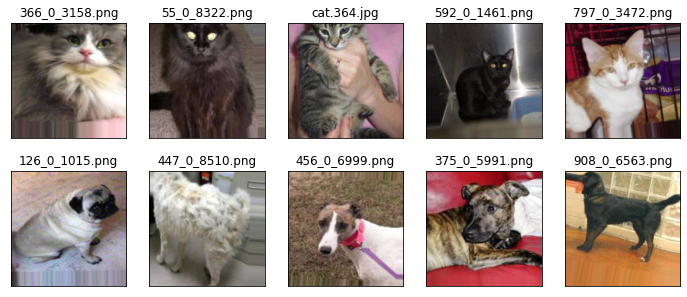

In [14]:
plt.figure(figsize=(12,5))
cat_fnames = glob(f'{train_cats_dir}/*')
dog_fnames = glob(f'{train_dogs_dir}/*')
for i in range(5):
    img = Image.open(cat_fnames[i])
    plt.subplot(2,5,i+1)
    plt.imshow(img), plt.title(cat_fnames[i].split('/')[-1]), plt.xticks([]), plt.yticks([])
    img = Image.open(dog_fnames[i])
    plt.subplot(2,5,i+1+5)
    plt.imshow(img), plt.title(dog_fnames[i].split('/')[-1]), plt.xticks([]), plt.yticks([])
plt.show()

- 모델 구성

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [16]:
model = Sequential([
    Conv2D(16, kernel_size=(3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)        0

- 모델 설정

In [17]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

- 파일에서 이미지 데이터 읽어오는 방법

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [19]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 21993 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- callback 정의

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-cat-dog-v3.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

- 모델 실행

In [21]:
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=100,        # 한번의 epoch에서 훈련에 사용할 batch의 갯수
    validation_steps=50,        # 한번의 epoch가 끝났을 때, 테스트에 사용되는 batch의 갯수
    verbose=2,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.68283, saving model to best-cat-dog-v3.h5
100/100 - 18s - loss: 0.7957 - accuracy: 0.5355 - val_loss: 0.6828 - val_accuracy: 0.5950 - 18s/epoch - 176ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 0.68283 to 0.65852, saving model to best-cat-dog-v3.h5
100/100 - 6s - loss: 0.6762 - accuracy: 0.6045 - val_loss: 0.6585 - val_accuracy: 0.5940 - 6s/epoch - 56ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 0.65852 to 0.61094, saving model to best-cat-dog-v3.h5
100/100 - 6s - loss: 0.6406 - accuracy: 0.6240 - val_loss: 0.6109 - val_accuracy: 0.6590 - 6s/epoch - 57ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 0.61094 to 0.61073, saving model to best-cat-dog-v3.h5
100/100 - 6s - loss: 0.6028 - accuracy: 0.6720 - val_loss: 0.6107 - val_accuracy: 0.6580 - 6s/epoch - 56ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 0.61073 to 0.58531, saving model to best-cat-dog-v3.h5
100/100 - 6s - loss: 0.6120 - acc

In [22]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

- 텍스트 이미지 분류

In [23]:
from google.colab import files

up = files.upload()

In [27]:
for fname in up.keys():
    img = Image.open(fname)
    img = center_image(img)
    classes = best_model.predict(np.array(img).reshape(1,150,150,3))
    print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

- 학습과정 시각화

In [25]:
import numpy as np
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

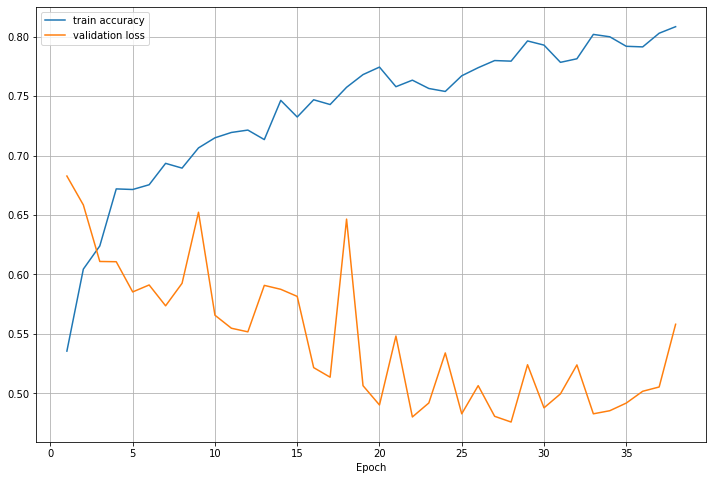

In [26]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()